NER dataset to recognize the name entity from the sentences.

Tags:

* ORGANIZATION - Georgia-Pacific Corp., WHO
* PERSON - Eddy Bonte, President Obama
* LOCATION - Murray River, Mount Everest
* DATE - June, 2008-06-29
* TIME - two fifty a m, 1:30 p.m.
* MONEY - 175 million Canadian Dollars, GBP 10.40
* PERCENT - twenty pct, 18.75 %
* FACILITY - Washington Monument, Stonehenge
* GPE - South East Asia, Midlothian

Link: https://www.kaggle.com/datasets/debasisdotcom/name-entity-recognition-ner-dataset


In [1]:
!pip install -qU transformers
!pip install -qU datasets
!pip install -qU seqeval


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 18.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 17.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 38.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 34.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 492.4/492.4 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 13.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 1.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [2]:
import re
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import time
import json

from transformers import AutoTokenizer, BertForTokenClassification
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler,random_split, Dataset
from torch.nn.functional import pad
from transformers import BertForSequenceClassification, AdamW, BertConfig,BertTokenizer,get_linear_schedule_with_warmup
from tqdm.auto import tqdm
from sklearn.utils import shuffle
import datasets

import warnings
warnings.filterwarnings(action="ignore")

pd.set_option('display.max_colwidth', 3000)
pd.set_option('display.max_columns', None)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [5]:
CYELGREENBG = '\033[43m'
CFUKSIABG = '\033[45m'
CLBLUEBG = '\033[46m'
CGREYBG    = '\33[100m'
CREDBG    = '\33[101m'
CGREENBG  = '\33[102m'
CYELLOWBG = '\33[103m'
CBLUEBG   = '\33[104m'
CVIOLETBG = '\33[105m'
CBEIGEBG  = '\33[106m'
CEND  = '\33[107m'

color_mapping = {'O': CEND, 'GEO': CYELLOWBG, 'GPE': CREDBG, 'PER': CBLUEBG, 'ORG':CVIOLETBG,
                 'TIM': CBEIGEBG, 'ART': CYELGREENBG, 'NAT': CFUKSIABG, 'EVE':CLBLUEBG
                 }

## Data preprocessing

In [6]:
df = pd.read_csv("data/dataset.csv", encoding='unicode_escape').rename(columns={"Sentence #": "Sentence"})
df["Tag"] = df["Tag"].apply(lambda x: x.upper())
df["TagGeneral"] = df["Tag"].apply(lambda x: x.split("-")[-1])
df["TagPos"] = df["Tag"].apply(lambda x: x.split("-")[0])
df

,Sentence,Word,POS,Tag,TagGeneral,TagPos
0,Sentence: 1,Thousands,NNS,O,O,O
1,NaN,of,IN,O,O,O
2,NaN,demonstrators,NNS,O,O,O
3,NaN,have,VBP,O,O,O
4,NaN,marched,VBN,O,O,O
...,...,...,...,...,...,...
1048570,NaN,they,PRP,O,O,O
1048571,NaN,responded,VBD,O,O,O
1048572,NaN,to,TO,O,O,O
1048573,NaN,the,DT,O,O,O


In [7]:
tag_list = df["Tag"].unique()
tag_general_list = df["TagGeneral"].unique()

n_tags = len(tag_list)
n_tag_general = len(tag_general_list)

tags2ids = {tag: i for i, tag in enumerate(tag_list)}
ids2tags = {i: tag for i, tag in enumerate(tag_list)}

df["TagId"] = df["Tag"].map(tags2ids)
df

,Sentence,Word,POS,Tag,TagGeneral,TagPos,TagId
0,Sentence: 1,Thousands,NNS,O,O,O,0
1,NaN,of,IN,O,O,O,0
2,NaN,demonstrators,NNS,O,O,O,0
3,NaN,have,VBP,O,O,O,0
4,NaN,marched,VBN,O,O,O,0
...,...,...,...,...,...,...,...
1048570,NaN,they,PRP,O,O,O,0
1048571,NaN,responded,VBD,O,O,O,0
1048572,NaN,to,TO,O,O,O,0
1048573,NaN,the,DT,O,O,O,0


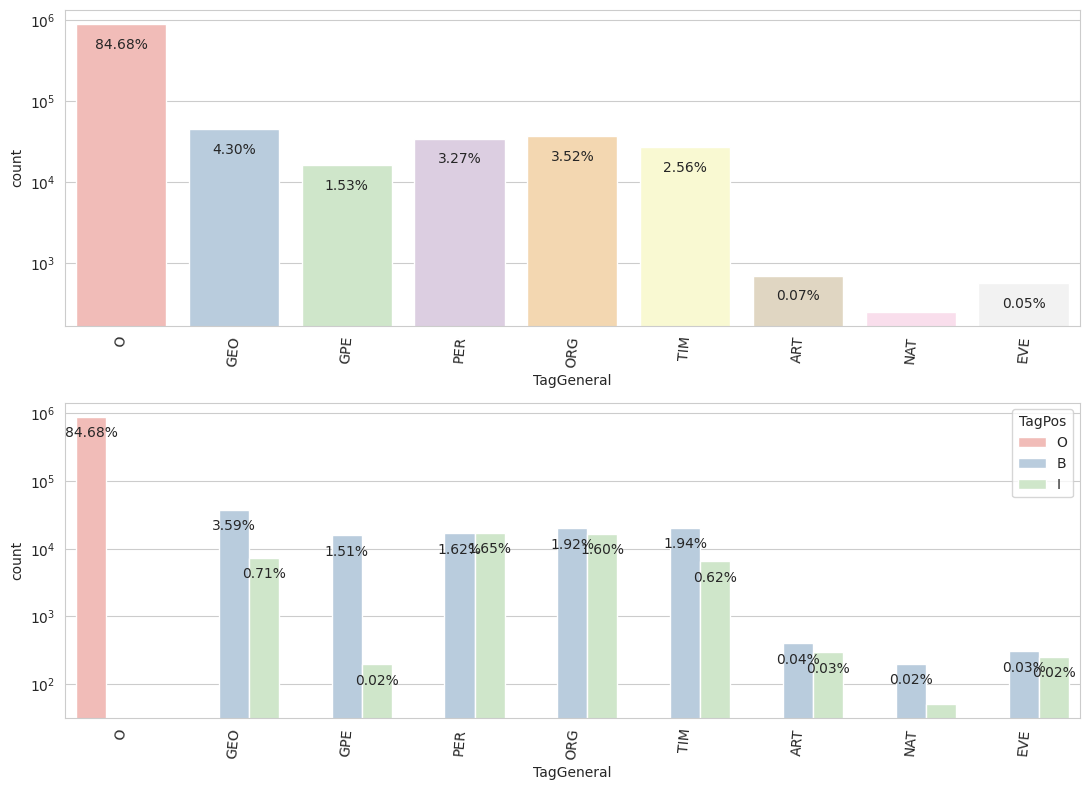

In [8]:
sns.set_palette(palette="Pastel1")
sns.set_style("whitegrid")

fig, axs =plt.subplots(2,1, figsize=(11,8))
sns.countplot(x=df['TagGeneral'], ax=axs[0])
sns.countplot(x=df['TagGeneral'], ax=axs[1], hue =df["TagPos"])
axs[0].tick_params(axis='x', rotation=85)
axs[1].tick_params(axis='x', rotation=85)

total = len(df)
for ax in axs:
  ax.set_yscale("log")
  for p in ax.patches:
      percentage = '{:.2f}%'.format(100 * p.get_height()/total)
      x = p.get_x() + p.get_width()/2
      y = p.get_height()/2
      ax.annotate(percentage, (x, y), ha='center', fontsize=10, rotation=0)
fig.tight_layout()
fig.show()

In [9]:

df["Sentence"] = df["Sentence"].fillna(method='ffill')
df = df.groupby("Sentence").agg(list).reset_index().drop("Sentence", axis=1)
df

,Word,POS,Tag,TagGeneral,TagPos,TagId
0,"[Thousands, of, demonstrators, have, marched, through, London, to, protest, the, war, in, Iraq, and, demand, the, withdrawal, of, British, troops, from, that, country, .]","[NNS, IN, NNS, VBP, VBN, IN, NNP, TO, VB, DT, NN, IN, NNP, CC, VB, DT, NN, IN, JJ, NNS, IN, DT, NN, .]","[O, O, O, O, O, O, B-GEO, O, O, O, O, O, B-GEO, O, O, O, O, O, B-GPE, O, O, O, O, O]","[O, O, O, O, O, O, GEO, O, O, O, O, O, GEO, O, O, O, O, O, GPE, O, O, O, O, O]","[O, O, O, O, O, O, B, O, O, O, O, O, B, O, O, O, O, O, B, O, O, O, O, O]","[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0]"
1,"[Iranian, officials, say, they, expect, to, get, access, to, sealed, sensitive, parts, of, the, plant, Wednesday, ,, after, an, IAEA, surveillance, system, begins, functioning, .]","[JJ, NNS, VBP, PRP, VBP, TO, VB, NN, TO, JJ, JJ, NNS, IN, DT, NN, NNP, ,, IN, DT, NNP, NN, NN, VBZ, VBG, .]","[B-GPE, O, O, O, O, O, O, O, O, O, O, O, O, O, O, B-TIM, O, O, O, B-ORG, O, O, O, O, O]","[GPE, O, O, O, O, O, O, O, O, O, O, O, O, O, O, TIM, O, O, O, ORG, O, O, O, O, O]","[B, O, O, O, O, O, O, O, O, O, O, O, O, O, O, B, O, O, O, B, O, O, O, O, O]","[2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 0, 0, 0, 5, 0, 0, 0, 0, 0]"
2,"[Helicopter, gunships, Saturday, pounded, militant, hideouts, in, the, Orakzai, tribal, region, ,, where, many, Taliban, militants, are, believed, to, have, fled, to, avoid, an, earlier, military, offensive, in, nearby, South, Waziristan, .]","[NN, NNS, NNP, VBD, JJ, NNS, IN, DT, NNP, JJ, NN, ,, WRB, JJ, NNP, NNS, VBP, VBN, TO, VB, VBN, TO, VB, DT, JJR, JJ, NN, IN, JJ, NNP, NNP, .]","[O, O, B-TIM, O, O, O, O, O, B-GEO, O, O, O, O, O, B-ORG, O, O, O, O, O, O, O, O, O, O, O, O, O, O, B-GEO, I-GEO, O]","[O, O, TIM, O, O, O, O, O, GEO, O, O, O, O, O, ORG, O, O, O, O, O, O, O, O, O, O, O, O, O, O, GEO, GEO, O]","[O, O, B, O, O, O, O, O, B, O, O, O, O, O, B, O, O, O, O, O, O, O, O, O, O, O, O, O, O, B, I, O]","[0, 0, 7, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 4, 0]"
3,"[They, left, after, a, tense, hour-long, standoff, with, riot, police, .]","[PRP, VBD, IN, DT, NN, JJ, NN, IN, NN, NNS, .]","[O, O, O, O, O, O, O, O, O, O, O]","[O, O, O, O, O, O, O, O, O, O, O]","[O, O, O, O, O, O, O, O, O, O, O]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
4,"[U.N., relief, coordinator, Jan, Egeland, said, Sunday, ,, U.S., ,, Indonesian, and, Australian, military, helicopters, are, ferrying, out, food, and, supplies, to, remote, areas, of, western, Aceh, province, that, ground, crews, can, not, reach, .]","[NNP, NN, NN, NNP, NNP, VBD, NNP, ,, NNP, ,, JJ, CC, JJ, JJ, NNS, VBP, VBG, RP, NN, CC, NNS, TO, VB, NNS, IN, JJ, NNP, NN, IN, NN, NNS, MD, RB, VB, .]","[B-GEO, O, O, B-PER, I-PER, O, B-TIM, O, B-GEO, O, B-GPE, O, B-GPE, O, O, O, O, O, O, O, O, O, O, O, O, O, B-GEO, O, O, O, O, O, O, O, O]","[GEO, O, O, PER, PER, O, TIM, O, GEO, O, GPE, O, GPE, O, O, O, O, O, O, O, O, O, O, O, O, O, GEO, O, O, O, O, O, O, O, O]","[B, O, O, B, I, O, B, O, B, O, B, O, B, O, O, O, O, O, O, O, O, O, O, O, O, O, B, O, O, O, O, O, O, O, O]","[1, 0, 0, 3, 10, 0, 7, 0, 1, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]"
...,...,...,...,...,...,...
47954,"[Opposition, leader, Mir, Hossein, Mousavi, has, said, he, plans, to, attend, and, activists, have, encouraged, people, to, capitalize, on, the, large, gatherings, to, protest, the, disputed, re-election, of, President, Mahmoud, Ahmadinejad, .]","[NNP, NN, NNP, NNP, NNP, VBZ, VBN, PRP, VBZ, TO, VB, CC, NNS, VBP, VBN, NNS, TO, VB, IN, DT, JJ, NNS, TO, VB, DT, JJ, NN, IN, NNP, NNP, NNP, .]","[O, O, O, B-PER, I-PER, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, B-PER, I-PER, I-PER, O]","[O, O, O, PER, PER, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, PER, PER, PER, O]","[O, O, O, B, I, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, B, I, I, O]","[0, 0, 0, 3

## Model

In [10]:
huggingface_model = "bert-base-cased"
tokenizer = AutoTokenizer.from_pretrained(huggingface_model, do_lower_case=True)
tokenizer.special_tokens_map

{'unk_token': '[UNK]',
 'sep_token': '[SEP]',
 'pad_token': '[PAD]',
 'cls_token': '[CLS]',
 'mask_token': '[MASK]'}

In [11]:
model = BertForTokenClassification.from_pretrained(
    huggingface_model,
    num_labels = n_tags,
    output_attentions = False,
    output_hidden_states = False,
).to(device)

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Dataset & Dataloaders

In [12]:
class CustomDataset(torch.utils.data.Dataset):

    def __init__(self, df, tokenizer):
        super().__init__()
        self.tokenizer = tokenizer
        self.inputs = df["Word"].values
        self.labels =df["TagId"].values
        self.len = len(self.labels)

    def __getitem__(self, idx):
        encoded_dict = tokenizer(self.inputs[idx],
                                 is_split_into_words=True,
                                 add_special_tokens = True,
                                 return_attention_mask = True,
                                 return_tensors = 'pt',
                   )

        token_labels = self.__create_token_labels(self.labels[idx], encoded_dict.word_ids())
        return encoded_dict['input_ids'][0], encoded_dict['token_type_ids'][0], encoded_dict['attention_mask'][0], token_labels

    def __create_token_labels(self, labels, word_ids ):
        extended_labels = [-100 if word_id is None else labels[word_id] for word_id in word_ids]
        return torch.tensor(extended_labels).to(torch.int64)

    def __len__(self):
        return self.len

In [13]:
def collate_fn(batch):
    max_len = max([len(sample[0]) for sample in batch])

    ids = []
    token_types = []
    attention_masks = []
    labels = []

    for sample in batch:
        pad_length = max_len - len(sample[0])
        ids.append(pad(sample[0], (0, pad_length), value=0))
        token_types.append(pad(sample[1], (0, pad_length), value=0))
        attention_masks.append(pad(sample[2], (0, pad_length), value=0))
        labels.append(pad(sample[3], (0, pad_length), value=-100))
    return torch.stack(ids), torch.stack(token_types), torch.stack(attention_masks), torch.stack(labels)

In [14]:
dataset = CustomDataset(df, tokenizer)
train_size = int(0.8 * len(dataset))
validation_size = len(dataset)  - train_size
train_dataset, validation_dataset = random_split(dataset, [train_size, validation_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(validation_size))

38,367 training samples
9,592 validation samples


In [15]:
batch_size = 8

train_dataloader = DataLoader(
            train_dataset,
            sampler = RandomSampler(train_dataset),
            batch_size = batch_size,
            collate_fn=collate_fn
        )

validation_dataloader = DataLoader(
            validation_dataset,
            sampler = SequentialSampler(validation_dataset),
            batch_size = batch_size,
            collate_fn=collate_fn
        )

In [16]:
optimizer = AdamW(model.parameters(),
                  lr = 1e-5,
                  eps = 1e-8
                  )


# Training

In [30]:
start_time = time.time()

EPOCHS = 5
avg_train_accuracy = []
avg_train_loss = []
avg_val_loss = []
avg_val_accuracy = []

for epoch_i in range(0, EPOCHS):

    running_train_loss = 0
    running_train_accuracy = 0
    running_val_loss = 0
    running_val_accuracy = 0

    model.train()

    loop = tqdm(train_dataloader)

    for batch in loop:
        b_input_ids = batch[0].to(device)
        b_input_token_type = batch[1].to(device)
        b_input_mask = batch[2].to(device)
        b_labels = batch[3].to(device)

        optimizer.zero_grad()

        output = model(b_input_ids,
                       token_type_ids=b_input_token_type,
                       attention_mask=b_input_mask,
                       labels=b_labels)

        loss = output.loss
        running_train_loss += loss.item()
        loss.backward()
        optimizer.step()

        loop.set_description(f"Training. Epoch [{epoch_i}/{EPOCHS}]. Loss {loss.item()}")

    avg_train_accuracy.append(running_train_accuracy / train_size)
    avg_train_loss.append(running_train_loss / train_size)


    model.eval()
    with torch.no_grad():
        loop = tqdm(validation_dataloader)
        for batch in loop:

            b_input_ids = batch[0].to(device)
            b_input_token_type = batch[1].to(device)
            b_input_mask = batch[2].to(device)
            b_labels = batch[3].to(device)

            output = model(b_input_ids,
                          token_type_ids=b_input_token_type,
                          attention_mask=b_input_mask,
                          labels=b_labels)

            loss = output.loss
            running_val_loss += loss.item()

        loop.set_description(f"Validation. Epoch [{epoch_i}/{EPOCHS}]. Loss {loss.item()}")

    avg_val_accuracy.append(running_val_accuracy / validation_size)
    avg_val_loss.append(running_val_loss / validation_size)

  0%|          | 0/4796 [00:00<?, ?it/s]

  0%|          | 0/1199 [00:00<?, ?it/s]

  0%|          | 0/4796 [00:00<?, ?it/s]

  0%|          | 0/1199 [00:00<?, ?it/s]

  0%|          | 0/4796 [00:00<?, ?it/s]

  0%|          | 0/1199 [00:00<?, ?it/s]

  0%|          | 0/4796 [00:00<?, ?it/s]

  0%|          | 0/1199 [00:00<?, ?it/s]

  0%|          | 0/4796 [00:00<?, ?it/s]

  0%|          | 0/1199 [00:00<?, ?it/s]

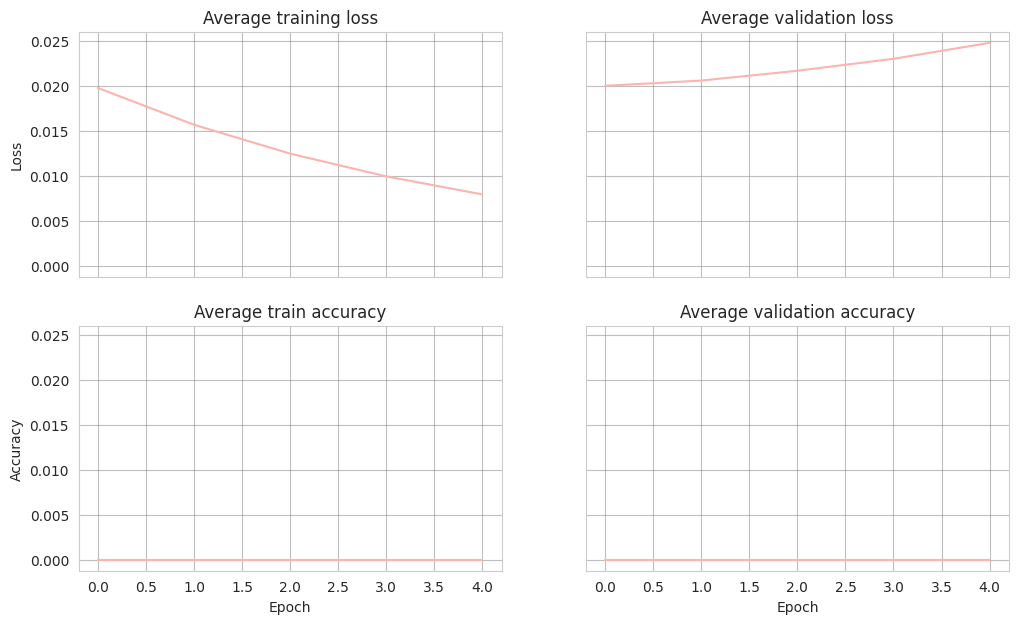

In [31]:
fig, axs = plt.subplots(2,2, figsize=(12, 7), sharex=True, sharey=True)

axs[0][0].plot(avg_train_loss)
axs[0][0].set_title("Average training loss")

axs[0][1].plot(avg_val_loss)
axs[0][1].set_title("Average validation loss")

axs[1][0].plot(avg_train_accuracy)
axs[1][0].set_title("Average train accuracy")

axs[1][1].plot(avg_val_accuracy)
axs[1][1].set_title("Average validation accuracy")

axs[1][0].set_xlabel("Epoch")
axs[1][1].set_xlabel("Epoch")
axs[1][0].set_ylabel("Accuracy")
axs[0][0].set_ylabel("Loss")

for row in axs:
    for ax in row:
        ax.grid(c='gray', alpha=0.5)

In [32]:
def evaluate(model, dataloader):

    metric = datasets.load_metric("seqeval")

    all_predictions = []
    all_labels = []

    model.eval()
    with torch.no_grad():
        for batch in dataloader:
            b_input_ids = batch[0].to(device)
            b_input_token_type = batch[1].to(device)
            b_input_mask = batch[2].to(device)
            b_labels = batch[3].to(device)

            output = model(b_input_ids,
                          token_type_ids=b_input_token_type,
                          attention_mask=b_input_mask,
                          labels=b_labels)

            labels = b_labels.to('cpu').numpy()
            predictions = torch.argmax(output.logits.detach().cpu(), 2).numpy()

            for prediction, label in zip(predictions, labels):
                for pred_idx, label_idx in zip(prediction, label):
                    if label_idx != -100:
                        all_predictions.append(ids2tags[pred_idx])
                        all_labels.append(ids2tags[label_idx])

    return metric.compute(predictions=[all_predictions], references=[all_labels])

In [33]:
evaluate(model, train_dataloader)

{'ART': {'precision': 0.9015748031496063,
  'recall': 0.8718274111675127,
  'f1': 0.8864516129032258,
  'number': 788},
 'EVE': {'precision': 0.8440366972477065,
  'recall': 0.8598130841121495,
  'f1': 0.8518518518518519,
  'number': 428},
 'GEO': {'precision': 0.9597020991727634,
  'recall': 0.9744258872651357,
  'f1': 0.9670079498915924,
  'number': 82388},
 'GPE': {'precision': 0.9784576063427484,
  'recall': 0.9782535005606112,
  'f1': 0.9783555428064776,
  'number': 38351},
 'NAT': {'precision': 0.8476454293628809,
  'recall': 0.7707808564231738,
  'f1': 0.8073878627968338,
  'number': 397},
 'ORG': {'precision': 0.94019970829126,
  'recall': 0.914248308967925,
  'f1': 0.9270424249128824,
  'number': 36664},
 'PER': {'precision': 0.9554827077528274,
  'recall': 0.934558163396178,
  'f1': 0.9449046083024006,
  'number': 31188},
 'TIM': {'precision': 0.9832978071071918,
  'recall': 0.9805491657688612,
  'f1': 0.9819215629100452,
  'number': 34343},
 'overall_precision': 0.9622384554

In [34]:
evaluate(model, validation_dataloader)

{'ART': {'precision': 0.2883435582822086,
  'recall': 0.27485380116959063,
  'f1': 0.281437125748503,
  'number': 171},
 'EVE': {'precision': 0.35714285714285715,
  'recall': 0.2604166666666667,
  'f1': 0.3012048192771084,
  'number': 96},
 'GEO': {'precision': 0.8650122203421696,
  'recall': 0.8910191236988623,
  'f1': 0.8778230903150415,
  'number': 20655},
 'GPE': {'precision': 0.9398435118382278,
  'recall': 0.9497843499691928,
  'f1': 0.9447877828285408,
  'number': 9738},
 'NAT': {'precision': 0.5636363636363636,
  'recall': 0.5210084033613446,
  'f1': 0.5414847161572053,
  'number': 119},
 'ORG': {'precision': 0.7077720207253886,
  'recall': 0.6719501530389156,
  'f1': 0.689396063477822,
  'number': 9148},
 'PER': {'precision': 0.8150075311515815,
  'recall': 0.783157894736842,
  'f1': 0.7987653492585386,
  'number': 7600},
 'TIM': {'precision': 0.9142281720175335,
  'recall': 0.9046893317702227,
  'f1': 0.9094337399092568,
  'number': 8530},
 'overall_precision': 0.851741845443

# Save model

In [36]:
model.save_pretrained("ner_model")
tokenizer.save_pretrained("tokenizer")

config = json.load(open("ner_model/config.json"))
config["id2label"] = ids2tags
config["label2id"] = tags2ids
json.dump(config, open("ner_model/config.json","w"))

# Predict tags using hand-made function

In [ ]:
from collections import Counter

def get_predicted_tag(tags, scores):
    most_common_label= Counter(tags).most_common()[0][0]
    predicted_tag = ids2tags[most_common_label]
    return {"tag": predicted_tag, "score": scores}


def predict(raw_text):

    raw_words = raw_text.split()
    encoded_dict = tokenizer(raw_words,
                             is_split_into_words=True,
                             add_special_tokens = True,
                             return_attention_mask = True,
                             return_tensors = 'pt'
                   )

    input_ids = encoded_dict['input_ids'][0].unsqueeze(0)
    input_token_type = encoded_dict['token_type_ids'][0].unsqueeze(0)
    input_mask = encoded_dict['attention_mask'][0].unsqueeze(0)

    output = model(input_ids, token_type_ids=input_token_type, attention_mask=input_mask)
    normalized_output = F.softmax(output.logits.detach().cpu(), dim=2)
    predictions = torch.max(normalized_output, 2)
    predicted_label = predictions.indices.numpy().flatten()
    predicted_scores = predictions.values.numpy().flatten()

    result = {}
    prev_token_id = None

    for token_id, predicted_label, score in zip(encoded_dict.word_ids(), predicted_label, predicted_scores):
        if token_id is None:
            continue
        elif token_id != prev_token_id:
            if prev_token_id is not None:
                result[raw_words[prev_token_id]] = get_predicted_tag(tags, scores)
            tags = []
            scores = []

        tags.append(predicted_label)
        scores.append(score)
        prev_token_id = token_id

    result[raw_words[prev_token_id]] = get_predicted_tag(tags, scores)

    print(encoded_dict.word_ids())

    for k, v in result.items():
        print(k, v)



In [26]:

def display_formatted_text(words, tags):
    formatted_text = " ".join([color_mapping[tag] + word for word, tag in zip(words, tags)]) + CEND
    print(formatted_text)

text = df.loc[0, "Word"]
tags = df.loc[0, "TagGeneral"]
display_formatted_text(text, tags)

Thousands of demonstrators have marched through London to protest the war in Iraq and demand the withdrawal of British troops from that country .


# Predict tags using transformers pipeline

In [29]:
from transformers import pipeline, AutoModelForTokenClassification

model_fine_tuned = AutoModelForTokenClassification.from_pretrained("ner_model")
nlp = pipeline("ner", model=model_fine_tuned, tokenizer=tokenizer, aggregation_strategy="first")

example = input()
ner_results = nlp(example)
print(ner_results)

Thousands of demonstrators have marched through London to protest the war in Iraq and demand the withdrawal of British troops from that country .
[{'entity_group': 'GEO', 'score': 0.96421456, 'word': 'london', 'start': 48, 'end': 54}, {'entity_group': 'GEO', 'score': 0.9923381, 'word': 'iraq', 'start': 77, 'end': 81}, {'entity_group': 'GPE', 'score': 0.9437061, 'word': 'british', 'start': 111, 'end': 118}]
